In [24]:
# import torch
# import model
# import helper
# import MyDataSet

In [25]:
# def return_counter_with_x_steps(z_one_image:torch.Tensor, steps_x_alpha_i:int=20):
#     # STEPS = steps
#     # STEPS = torch.linspace(1, steps_x_alpha_i, steps=steps_x_alpha_i)
#     z_ones = torch.ones(steps_x_alpha_i+1)
#     # torch.fill(z_ones,z_one_image.item())
#     STEPS = torch.linspace(0, steps_x_alpha_i, steps=steps_x_alpha_i+1)
#
#     STEPS = STEPS.unsqueeze(dim = 1)
#     STEPS = STEPS * z_one_image
#     print(f'{STEPS = }')
#     print(f'{z_one_image = }')
#     print(f'{z_ones = }')
#     print(f'{STEPS = }')
#     z_one_image = z_ones * torch.t(z_one_image)
#     # z_one_image = z_one_image.repeat(2,steps_x_alpha_i)
#     print('------')
#     print(f'{z_one_image = }')
#     # print(STEPS.unsqueeze(dim = 1))
#     iterweights = iter(pick_model.parameters())
#     w = next(iterweights).data[0]
#     w0 = next(iterweights).data[0]
#     alpha_i = - (z_one_image * w + w0) / torch.t(w) * w
#     # z_counter = z + torch.t(STEPS) * alpha_i * w
#     # z_counter = z + STEPS * torch.t(alpha_i) * w
#     z_counter = z + STEPS * alpha_i * w
#
#     with torch.no_grad():
#         z_counter_recons_img = model_copy_vae.decode(z_counter)
#         # plt.imshow(z_counter_recons_img.view(28,28))
#         # print(f'{z_counter = }')
#     print(z_counter_recons_img.view(-1, 1, 28, 28).shape)
#     return z_counter_recons_img.view(-1, 1, 28, 28)
#
#
#


In [26]:
# model_copy = model.VaeFinal_only_one_hidden_copy()
# model_copy = helper.import_model_name_weights_copy(model_x=model_copy, activate_eval=True)
# # dataset_test_4 = MyDataSet.MyDataSets_Subset_4(batch_size_train=-1)
# with torch.no_grad():
#     dataset_49 = MyDataSet.MyDataSets_Subset_4_9(batch_size_train=-1)
#     img_49_batch, label_49_batch = next(iter(dataset_49.train_loader_subset_changed_labels))
#     rec49, mu49, sigma49 = model_copy(img_49_batch.clone())
#     z = mu49

MyDataSets.MyDataSets_Subset_4_9.__init__


In [23]:
# counter_factuals = return_counter_with_x_steps(z_one_image=z[0], steps_x_alpha_i=20)
# print(counter_factuals.shape)

MyDataSets.MyDataSets_Subset_4_9.__init__


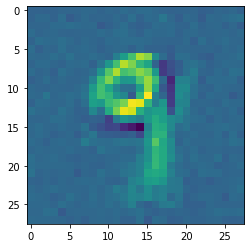

In [53]:
import torch
import model
import helper
import MyDataSet
import matplotlib.pyplot as plt
import model_probit
lattent_2class = model_probit.latent_space()
lattent_2class = helper.import_model_name(model_x=lattent_2class, activate_eval=True)
model_vae = model.VaeFinal_only_one_hidden_copy()
model_vae = helper.import_model_name_weights_copy(model_x=model_vae, activate_eval=True)
with torch.no_grad():
    dataset_49 = MyDataSet.MyDataSets_Subset_4_9(batch_size_train=-1)
    img_49_batch, label_49_batch = next(iter(dataset_49.train_loader_subset_changed_labels))
    rec49, mu49, sigma49 = model_vae(img_49_batch.clone())
    z = mu49
def return_counter_with_steps(z,steps=20):
    STEPS = steps
    iterweights = iter(lattent_2class.parameters())
    w = next(iterweights).data[0]
    w0 = next(iterweights).data[0]
    alpha_i = - (torch.t(z) * w + w0) / torch.t(w) * w
    z_counter = z + STEPS * alpha_i*w

    with torch.no_grad():
        z_counter_recons_img = model_vae.decode(z_counter)
        # plt.imshow(z_counter_recons_img.view(28,28))
        # print(f'{z_counter = }')

    return z_counter_recons_img.view(28,28)
plt.imshow(return_counter_with_steps(z=z[20],steps=20))
# plt.imshow(return_counter_with_steps(z=z[0],steps=100))

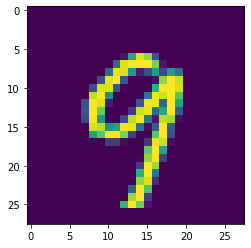

In [7]:
plt.imshow(img_49_batch[20].view(28,28))


In [13]:
device = 'cpu'

In [14]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)



    return torch.mean(XX + YY - 2. * XY)

In [54]:
# kernel ='multiscale'
# x= img_49_batch.view(-1,28*28)
#
# y,_,_= model_vae(x[0].view(-1,28*28))
# print(f'{y.shape = }')
# print(f'{x.shape = }')
# mmd = MMD(x=x,y=y,kernel=kernel)
# print(mmd)

def return_mmd(X, x_counter) :
    print(f'{X.shape = }')
    print(f'{x_counter.shape = }')
    kernel ='multiscale'
    X= X.view(-1,28*28)
    x_counter= x_counter.view(-1,28*28)
    # y,_,_= model_vae(X[0].view(-1,28*28))
    print('-------')
    print(f'{X.shape = }')
    print(f'{x_counter.shape = }')
    mmd = MMD(x=X,y=x_counter,kernel=kernel)
    return mmd
mmd = return_mmd(X=img_49_batch,x_counter=img_49_batch[20])
print(mmd)
counter_fact = return_counter_with_steps(z=z[20],steps=20)

X.shape = torch.Size([11791, 1, 28, 28])
x_counter.shape = torch.Size([1, 28, 28])
-------
X.shape = torch.Size([11791, 784])
x_counter.shape = torch.Size([1, 784])
tensor(3.9557)


In [47]:
kernel ='multiscale'
x= img_49_batch.view(-1,28*28)

y,_,_= model_vae(x[0].view(-1,28*28))
print(f'{y.shape = }')
print(f'{x.shape = }')
mmd = MMD(x=x,y=y,kernel=kernel)
print(mmd)

y.shape = torch.Size([1, 784])
x.shape = torch.Size([11791, 784])
tensor(3.9485, grad_fn=<MeanBackward0>)


In [58]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
              torch.zeros(xx.shape).to(device),
              torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)


    return torch.mean(XY)
    # return torch.mean(XX + YY - 2. * XY)

X.shape = torch.Size([11791, 1, 28, 28])
x_counter.shape = torch.Size([1, 28, 28])
-------
X.shape = torch.Size([11791, 784])
x_counter.shape = torch.Size([1, 784])
tensor(0.0465)
X.shape = torch.Size([11791, 1, 28, 28])
x_counter.shape = torch.Size([1, 784])
-------
X.shape = torch.Size([11791, 784])
x_counter.shape = torch.Size([1, 784])
X.shape = torch.Size([11791, 1, 28, 28])
x_counter.shape = torch.Size([28, 28])
-------
X.shape = torch.Size([11791, 784])
x_counter.shape = torch.Size([1, 784])


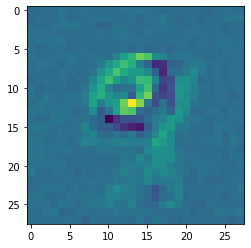

In [79]:
# kernel ='multiscale'
# x= img_49_batch.view(-1,28*28)
#
# y,_,_= model_vae(x[0].view(-1,28*28))
# print(f'{y.shape = }')
# print(f'{x.shape = }')
# mmd = MMD(x=x,y=y,kernel=kernel)
# print(mmd)

def return_mmd(X, x_counter) :
    print(f'{X.shape = }')
    print(f'{x_counter.shape = }')
    kernel ='multiscale'
    X= X.view(-1,28*28)
    x_counter= x_counter.view(-1,28*28)
    # y,_,_= model_vae(X[0].view(-1,28*28))
    print('-------')
    print(f'{X.shape = }')
    print(f'{x_counter.shape = }')
    mmd = MMD(x=X,y=x_counter,kernel=kernel)
    return mmd
index = 0
pick_img = img_49_batch[index]
mmd_total = return_mmd(X=img_49_batch,x_counter=pick_img)
print(mmd_total)
reconstruct_img,_,_ = model_vae(pick_img)
mmd_reconstruct_img = return_mmd(X=img_49_batch,x_counter=reconstruct_img)

counter_factual = return_counter_with_steps(z=z[index],steps=200)
mmd_counterfactual = return_mmd(X=img_49_batch,x_counter=counter_factual)
plt.imshow(counter_factual)




In [80]:
print(f'{mmd_total = }')
print(f'{mmd_reconstruct_img = }')
print(f'{mmd_counterfactual = }')

mmd_total = tensor(0.0465)
mmd_reconstruct_img = tensor(0.0587, grad_fn=<MeanBackward0>)
mmd_counterfactual = tensor(0.0043)
